 # Introduction
 State notebook purpose here

 ### Imports
 Import libraries and write settings here.

In [2]:
# Data manipulation
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython, display
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn

# Import APTs
from assets.api_keys import api_key

# Additional modules
from citipy import citipy
import requests
from requests.auth import HTTPBasicAuth
import json
import time


 # Analysis/Modeling
 Do work here

 ### Create a uniformly distributed DataFrame of cities across Latitudes and Longitudes

In [3]:
# Create Long and Latitude file if it hasn't already been created
try:
    city_df = pd.read_pickle('assets/city_df')
except IOError:
    # Get a representative sample of longitude and latitudes
    lats = np.random.uniform(-90., 90., 1500)
    longs = np.random.uniform(-180., 180., 1500)
    city_df = pd.DataFrame({'Latitude': lats, 'Longitude': longs })
    pd.to_pickle(city_df, 'assets/city_df')



In [4]:
city_df.head()



,Latitude,Longitude,city
0,66.923445,-178.524447,"egvekinot,ru"
1,-28.691295,105.165906,"carnarvon,au"
2,-58.509280,111.378456,"albany,au"
3,73.326901,-111.369206,"yellowknife,ca"
4,13.079430,-106.503989,"coahuayana,mx"


In [5]:
# Create the base url
base_url = f'http://api.openweathermap.org/data/2.5/find?'



In [6]:
# Test the API
city_name = "London,uk"
params = {'q': city_name, 'APPID': api_key, 'units': 'imperial'}
response = requests.get(base_url, params=params)
print(json.dumps(response.json(), indent=4, sort_keys=True))
type(response.status_code)

{
    "cod": "200",
    "count": 1,
    "list": [
        {
            "clouds": {
                "all": 8
            },
            "coord": {
                "lat": 51.5085,
                "lon": -0.1258
            },
            "dt": 1553570490,
            "id": 2643743,
            "main": {
                "humidity": 87,
                "pressure": 1034,
                "temp": 33.48,
                "temp_max": 39,
                "temp_min": 28
            },
            "name": "London",
            "rain": null,
            "snow": null,
            "sys": {
                "country": "GB"
            },
            "weather": [
                {
                    "description": "sky is clear",
                    "icon": "02n",
                    "id": 800,
                    "main": "Clear"
                }
            ],
            "wind": {
                "deg": 300,
                "speed": 2.24
            }
        }
    ],
    "message": "accurate"
}


int

In [7]:
# Method to use with DataFrame to find the closest cities.
def get_nearest_city(coor):
    city = citipy.nearest_city(coor['Latitude'], coor['Longitude'])
    return city.city_name + ',' + city.country_code


In [8]:
if not 'city' in city_df.columns:
    print('finding closests cities')
    city_df['city'] = city_df.apply(get_nearest_city, axis=1)
    pd.to_pickle(city_df, 'assets/city_df')
city_df.head()

,Latitude,Longitude,city
0,66.923445,-178.524447,"egvekinot,ru"
1,-28.691295,105.165906,"carnarvon,au"
2,-58.509280,111.378456,"albany,au"
3,73.326901,-111.369206,"yellowknife,ca"
4,13.079430,-106.503989,"coahuayana,mx"


In [9]:
# Check for Nan cities and remove duplicates
num_of_na = len(city_df[city_df['city'].isna()])
city_df = city_df.drop_duplicates(subset='city')
print(f'There were {num_of_na} cities not found')
print(city_df.shape)


There were 0 cities not found
(602, 3)


In [10]:
# Pull the api data and create a json file of it so I don't have to do
# an API all every time
try: 
    with open('assets/weather_data.json') as json_data:
        weather_data = json.load(json_data)
    print('File Found!')
except OSError:
    weather_data = []
    params = params = {'q': '', 'APPID': api_key, 'units': 'imperial'}
    for idx, city in enumerate(city_df['city'].values):
        params['q'] = city
        response = requests.get(base_url, params=params)
        while response.status_code != 200:
            print(f'Request for {city} failed with code {response.status_code}. Trying again')
            time.sleep(5)
        if response.json()['count'] > 0:
            print(f'Adding weather data for {city}')
            weather_data.append(response.json()['list'][0])
        else:
            print(f'{city} not found...' )
    # Write to file
    with open('assets/weather_data.json', 'w') as json_file:
        json.dump(weather_data, json_file)

File Found!


In [11]:
# Load json into DataFrame for analysis
weather_df = json_normalize(weather_data)

 # Results
 Show graphs and stats here

In [13]:
plt.style.use('ggplot')


Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Temperature (F)')

Text(0.5, 0, 'Latitude')

Text(0, 0.5, '% Humidity')

Text(0.5, 0, 'Latidude')

Text(0, 0.5, '% Cloudiness')

Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Wind Speed (mph)')

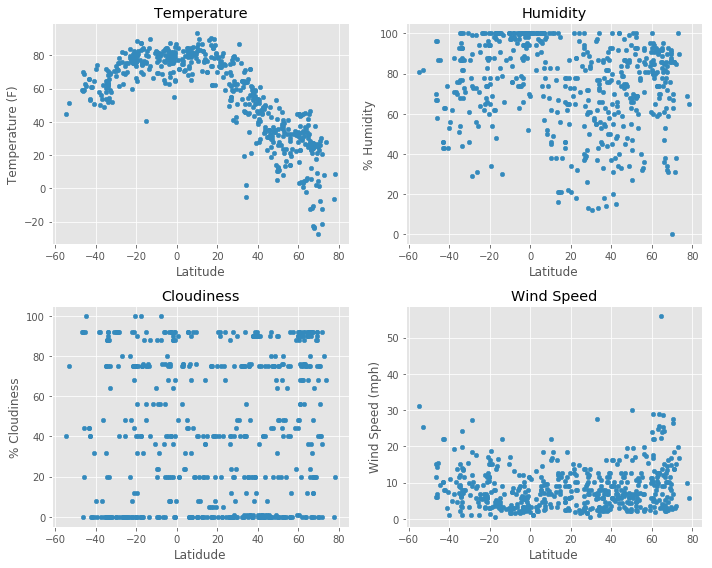

In [14]:
# Plot the figures
fig, ax_array = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
ax1 = ax_array[0][0]
ax2 = ax_array[0][1]
ax3 = ax_array[1][0]
ax4 = ax_array[1][1]

weather_df.plot(x='coord.lat', y='main.temp', kind='scatter', ax=ax1, title='Temperature')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Temperature (F)')

weather_df.plot(x='coord.lat', y='main.humidity', kind='scatter', ax=ax2, title='Humidity')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('% Humidity')

weather_df.plot(x='coord.lat', y='clouds.all', kind='scatter', ax=ax3, title='Cloudiness', )
ax3.set_xlabel('Latidude')
ax3.set_ylabel('% Cloudiness')

weather_df.plot(x='coord.lat', y='wind.speed', kind='scatter', ax=ax4, title='Wind Speed')
ax4.set_xlabel('Latitude')
ax4.set_ylabel('Wind Speed (mph)')
fig.tight_layout()

 # Conclusions and Next Steps
 Summarize findings here
 1. From the nice bell-shaped curve in the temperature plot, we can see that the temperature does indeed increase as we approach the equator
 2. We can also note that there is clearly no correlation between Humidity, Cloudiness, or Windspeed compared with respect to Latitude.
 3. Suprisingly